In [2]:
import os, shutil
import warnings
import pathlib
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [32]:
base_dir = '/home/kailash/VScode Python projects/tf/conv/small_dataset/'

In [33]:
train_dir = os.path.join(base_dir,'train')

validation_dir = os.path.join(base_dir, 'validation')

test_dir = os.path.join(base_dir, 'test')

In [34]:
import tensorflow as tf

In [3]:
import keras_tuner as kt


In [35]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [36]:
import tensorflow as tf
from tensorflow import keras


In [37]:
train_dir = pathlib.Path(train_dir)

In [38]:
train_ds = tf.data.Dataset.list_files(str(train_dir/'*/*'), shuffle=False)

In [39]:
validation_dir = pathlib.Path(validation_dir)

In [40]:
val_ds = tf.data.Dataset.list_files(str(validation_dir/'*/*'), shuffle=False)

In [41]:
train_ds

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [42]:
AUTOTUNE = tf.data.AUTOTUNE

In [43]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == ['cats','dogs']
  # Integer encode the label
  return tf.argmax(one_hot)

In [44]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [150, 150])

In [45]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [46]:
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [47]:
IMG_SIZE = 150

resize_and_rescale = tf.keras.Sequential([
   tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
   tf.keras.layers.Rescaling(1./255)
])

In [48]:
data_augmentation = tf.keras.Sequential([
   tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomTranslation(.2,.2),
  tf.keras.layers.RandomZoom(.2)
])
 

In [49]:
train_ds


<ParallelMapDataset element_spec=(TensorSpec(shape=(150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [50]:
batch_size = 20
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [51]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)


In [52]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [53]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32,(3,3),padding = "same",activation="relu",input_shape=(150,150,3)))
model.add(tf.keras.layers.MaxPooling2D((2,3)))
model.add(tf.keras.layers.Conv2D(64, (3, 3),padding = "same", activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), padding = "same",activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), padding = "same",activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


In [ ]:
def model_builder(hp):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32,(3,3),padding = "same",activation="relu",input_shape=(150,150,3)))
    model.add(tf.keras.layers.MaxPooling2D((2,3)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3),padding = "same", activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(128, (3, 3), padding = "same",activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(128, (3, 3), padding = "same",activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.5))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    model.add(keras.layers.Dense(10))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

    return model

In [54]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 75, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 50, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 37, 25, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 37, 25, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 18, 12, 128)     

In [55]:

model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4,decay=1e-6),metrics=['acc'])

In [56]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("cats_dog",save_best_only=True)

In [57]:
# early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

In [58]:
root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")+'dataset_map'
    return os.path.join(root_logdir, run_id)


run_logdir = get_run_logdir()


In [59]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir,profile_batch='10, 15',histogram_freq=1)

In [60]:
history = model.fit(train_ds,epochs=100,validation_data=val_ds,callbacks=[checkpoint_cb,tensorboard_cb])

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.6466 - acc: 0.6300

INFO:tensorflow:Assets written to: cats_dog/assets


INFO:tensorflow:Assets written to: cats_dog/assets


100/100 [==============================] - 16s 136ms/step - loss: 0.6466 - acc: 0.6300 - val_loss: 0.7491 - val_acc: 0.5000
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.6933 - acc: 0.5495

INFO:tensorflow:Assets written to: cats_dog/assets


INFO:tensorflow:Assets written to: cats_dog/assets


100/100 [==============================] - 7s 68ms/step - loss: 0.6933 - acc: 0.5495 - val_loss: 0.7164 - val_acc: 0.5000
Epoch 3/100
100/100 [==============================] - 5s 48ms/step - loss: 0.6981 - acc: 0.5260 - val_loss: 0.7529 - val_acc: 0.5000
Epoch 4/100
 99/100 [============================>.] - ETA: 0s - loss: 0.7103 - acc: 0.4631

INFO:tensorflow:Assets written to: cats_dog/assets


INFO:tensorflow:Assets written to: cats_dog/assets


100/100 [==============================] - 7s 70ms/step - loss: 0.7101 - acc: 0.4645 - val_loss: 0.6926 - val_acc: 0.5000
Epoch 5/100
100/100 [==============================] - 5s 48ms/step - loss: 0.6946 - acc: 0.4110 - val_loss: 0.6931 - val_acc: 0.5010
Epoch 6/100
100/100 [==============================] - 5s 49ms/step - loss: 0.6933 - acc: 0.4500 - val_loss: 0.6930 - val_acc: 0.5010
Epoch 7/100
100/100 [==============================] - 6s 50ms/step - loss: 0.6932 - acc: 0.4540 - val_loss: 0.6930 - val_acc: 0.5000
Epoch 8/100
100/100 [==============================] - 5s 45ms/step - loss: 0.6932 - acc: 0.4765 - val_loss: 0.6930 - val_acc: 0.5010
Epoch 9/100
100/100 [==============================] - 6s 51ms/step - loss: 0.6931 - acc: 0.4890 - val_loss: 0.6928 - val_acc: 0.5010
Epoch 10/100
100/100 [==============================] - 5s 50ms/step - loss: 0.6933 - acc: 0.4645 - val_loss: 0.6929 - val_acc: 0.5010
Epoch 11/100
100/100 [==============================] - 5s 41ms/step - lo

INFO:tensorflow:Assets written to: cats_dog/assets


INFO:tensorflow:Assets written to: cats_dog/assets


100/100 [==============================] - 6s 57ms/step - loss: 0.6931 - acc: 0.4710 - val_loss: 0.6921 - val_acc: 0.5010
Epoch 14/100
100/100 [==============================] - 5s 48ms/step - loss: 0.6881 - acc: 0.5275 - val_loss: 0.7242 - val_acc: 0.5000
Epoch 15/100
100/100 [==============================] - 5s 49ms/step - loss: 0.6950 - acc: 0.5430 - val_loss: 0.7207 - val_acc: 0.5000
Epoch 16/100
100/100 [==============================] - 5s 48ms/step - loss: 0.6981 - acc: 0.5215 - val_loss: 0.7135 - val_acc: 0.5000
Epoch 17/100
100/100 [==============================] - 5s 45ms/step - loss: 0.7051 - acc: 0.4505 - val_loss: 0.6928 - val_acc: 0.5010
Epoch 18/100
100/100 [==============================] - 5s 44ms/step - loss: 0.6936 - acc: 0.4705 - val_loss: 0.6929 - val_acc: 0.5060
Epoch 19/100
100/100 [==============================] - 5s 45ms/step - loss: 0.6932 - acc: 0.4525 - val_loss: 0.6928 - val_acc: 0.5080
Epoch 20/100
100/100 [==============================] - 6s 50ms/step

INFO:tensorflow:Assets written to: cats_dog/assets


INFO:tensorflow:Assets written to: cats_dog/assets


100/100 [==============================] - 6s 59ms/step - loss: 0.7002 - acc: 0.5510 - val_loss: 0.6918 - val_acc: 0.5190
Epoch 26/100
 99/100 [============================>.] - ETA: 0s - loss: 0.6927 - acc: 0.5111

INFO:tensorflow:Assets written to: cats_dog/assets


INFO:tensorflow:Assets written to: cats_dog/assets


100/100 [==============================] - 6s 59ms/step - loss: 0.6927 - acc: 0.5105 - val_loss: 0.6905 - val_acc: 0.5070
Epoch 27/100
100/100 [==============================] - 4s 40ms/step - loss: 0.6952 - acc: 0.5050 - val_loss: 0.6906 - val_acc: 0.5410
Epoch 28/100
 99/100 [============================>.] - ETA: 0s - loss: 0.6910 - acc: 0.5096

INFO:tensorflow:Assets written to: cats_dog/assets


INFO:tensorflow:Assets written to: cats_dog/assets


100/100 [==============================] - 6s 59ms/step - loss: 0.6909 - acc: 0.5120 - val_loss: 0.6856 - val_acc: 0.5610
Epoch 29/100
100/100 [==============================] - 4s 40ms/step - loss: 0.6777 - acc: 0.5595 - val_loss: 0.6991 - val_acc: 0.5180
Epoch 30/100
 99/100 [============================>.] - ETA: 0s - loss: 0.6845 - acc: 0.5672

INFO:tensorflow:Assets written to: cats_dog/assets


INFO:tensorflow:Assets written to: cats_dog/assets


100/100 [==============================] - 6s 59ms/step - loss: 0.6844 - acc: 0.5685 - val_loss: 0.6851 - val_acc: 0.5360
Epoch 31/100
100/100 [==============================] - 4s 40ms/step - loss: 0.6804 - acc: 0.5685 - val_loss: 0.7362 - val_acc: 0.5140
Epoch 32/100
100/100 [==============================] - 4s 40ms/step - loss: 0.6797 - acc: 0.5790 - val_loss: 0.7871 - val_acc: 0.5060
Epoch 33/100
100/100 [==============================] - 4s 41ms/step - loss: 0.6940 - acc: 0.5460 - val_loss: 0.6940 - val_acc: 0.5190
Epoch 34/100
100/100 [==============================] - 4s 40ms/step - loss: 0.6641 - acc: 0.6155 - val_loss: 0.7808 - val_acc: 0.5110
Epoch 35/100
100/100 [==============================] - 4s 40ms/step - loss: 0.6874 - acc: 0.5605 - val_loss: 0.6852 - val_acc: 0.5260
Epoch 36/100
100/100 [==============================] - ETA: 0s - loss: 0.6849 - acc: 0.5600

INFO:tensorflow:Assets written to: cats_dog/assets


INFO:tensorflow:Assets written to: cats_dog/assets


100/100 [==============================] - 6s 55ms/step - loss: 0.6849 - acc: 0.5600 - val_loss: 0.6678 - val_acc: 0.5680
Epoch 37/100
100/100 [==============================] - 4s 40ms/step - loss: 0.6426 - acc: 0.6320 - val_loss: 0.7675 - val_acc: 0.5240
Epoch 38/100
100/100 [==============================] - 4s 40ms/step - loss: 0.6785 - acc: 0.5675 - val_loss: 0.6954 - val_acc: 0.5480
Epoch 39/100
100/100 [==============================] - 4s 40ms/step - loss: 0.6602 - acc: 0.6110 - val_loss: 0.7182 - val_acc: 0.5410
Epoch 40/100
100/100 [==============================] - 4s 41ms/step - loss: 0.6645 - acc: 0.6045 - val_loss: 0.7196 - val_acc: 0.5620
Epoch 41/100
100/100 [==============================] - 4s 40ms/step - loss: 0.6413 - acc: 0.6390 - val_loss: 0.7203 - val_acc: 0.5520
Epoch 42/100
100/100 [==============================] - 4s 40ms/step - loss: 0.6435 - acc: 0.6275 - val_loss: 0.8239 - val_acc: 0.5680
Epoch 43/100
100/100 [==============================] - 4s 40ms/step

INFO:tensorflow:Assets written to: cats_dog/assets


INFO:tensorflow:Assets written to: cats_dog/assets


100/100 [==============================] - 6s 60ms/step - loss: 0.6069 - acc: 0.6395 - val_loss: 0.6435 - val_acc: 0.6200
Epoch 49/100
100/100 [==============================] - 5s 40ms/step - loss: 0.5837 - acc: 0.6770 - val_loss: 0.7626 - val_acc: 0.5930
Epoch 50/100
100/100 [==============================] - 4s 40ms/step - loss: 0.6021 - acc: 0.6605 - val_loss: 0.6462 - val_acc: 0.6330
Epoch 51/100
100/100 [==============================] - 4s 41ms/step - loss: 0.5852 - acc: 0.6945 - val_loss: 0.7754 - val_acc: 0.5830
Epoch 52/100
100/100 [==============================] - 4s 40ms/step - loss: 0.6020 - acc: 0.6790 - val_loss: 0.6610 - val_acc: 0.6100
Epoch 53/100
100/100 [==============================] - 4s 40ms/step - loss: 0.5719 - acc: 0.6910 - val_loss: 0.6801 - val_acc: 0.6300
Epoch 54/100
100/100 [==============================] - 4s 41ms/step - loss: 0.5760 - acc: 0.6900 - val_loss: 0.6692 - val_acc: 0.6310
Epoch 55/100
100/100 [==============================] - 4s 40ms/step

INFO:tensorflow:Assets written to: cats_dog/assets


INFO:tensorflow:Assets written to: cats_dog/assets


100/100 [==============================] - 6s 59ms/step - loss: 0.5757 - acc: 0.6915 - val_loss: 0.6374 - val_acc: 0.6510
Epoch 57/100
100/100 [==============================] - 4s 40ms/step - loss: 0.5614 - acc: 0.7145 - val_loss: 0.6581 - val_acc: 0.6400
Epoch 58/100
100/100 [==============================] - ETA: 0s - loss: 0.5939 - acc: 0.6660

INFO:tensorflow:Assets written to: cats_dog/assets


INFO:tensorflow:Assets written to: cats_dog/assets


100/100 [==============================] - 7s 67ms/step - loss: 0.5939 - acc: 0.6660 - val_loss: 0.6341 - val_acc: 0.6450
Epoch 59/100
100/100 [==============================] - 5s 44ms/step - loss: 0.5625 - acc: 0.7135 - val_loss: 0.6387 - val_acc: 0.6480
Epoch 60/100
 99/100 [============================>.] - ETA: 0s - loss: 0.5652 - acc: 0.7071

INFO:tensorflow:Assets written to: cats_dog/assets


INFO:tensorflow:Assets written to: cats_dog/assets


100/100 [==============================] - 7s 62ms/step - loss: 0.5639 - acc: 0.7090 - val_loss: 0.6120 - val_acc: 0.6560
Epoch 61/100
100/100 [==============================] - 5s 42ms/step - loss: 0.5580 - acc: 0.7120 - val_loss: 0.6142 - val_acc: 0.6610
Epoch 62/100
100/100 [==============================] - 5s 44ms/step - loss: 0.5541 - acc: 0.7210 - val_loss: 0.6451 - val_acc: 0.6490
Epoch 63/100
100/100 [==============================] - 5s 46ms/step - loss: 0.5565 - acc: 0.7135 - val_loss: 0.6497 - val_acc: 0.6620
Epoch 64/100
 99/100 [============================>.] - ETA: 0s - loss: 0.5581 - acc: 0.7040

INFO:tensorflow:Assets written to: cats_dog/assets


INFO:tensorflow:Assets written to: cats_dog/assets


100/100 [==============================] - 7s 67ms/step - loss: 0.5584 - acc: 0.7040 - val_loss: 0.5919 - val_acc: 0.6760
Epoch 65/100
100/100 [==============================] - 5s 46ms/step - loss: 0.5543 - acc: 0.7135 - val_loss: 0.6650 - val_acc: 0.6420
Epoch 66/100
100/100 [==============================] - 5s 47ms/step - loss: 0.5533 - acc: 0.7170 - val_loss: 0.6329 - val_acc: 0.6530
Epoch 67/100
100/100 [==============================] - ETA: 0s - loss: 0.5512 - acc: 0.7135

INFO:tensorflow:Assets written to: cats_dog/assets


INFO:tensorflow:Assets written to: cats_dog/assets


100/100 [==============================] - 7s 64ms/step - loss: 0.5512 - acc: 0.7135 - val_loss: 0.5555 - val_acc: 0.7030
Epoch 68/100
100/100 [==============================] - 5s 46ms/step - loss: 0.5360 - acc: 0.7290 - val_loss: 0.5750 - val_acc: 0.6830
Epoch 69/100
100/100 [==============================] - 5s 46ms/step - loss: 0.5174 - acc: 0.7420 - val_loss: 0.5992 - val_acc: 0.6760
Epoch 70/100
100/100 [==============================] - 5s 47ms/step - loss: 0.5423 - acc: 0.7155 - val_loss: 0.5840 - val_acc: 0.6840
Epoch 71/100
100/100 [==============================] - 5s 47ms/step - loss: 0.5348 - acc: 0.7290 - val_loss: 0.7007 - val_acc: 0.6240
Epoch 72/100
100/100 [==============================] - 5s 47ms/step - loss: 0.5536 - acc: 0.7105 - val_loss: 0.6059 - val_acc: 0.6580
Epoch 73/100
100/100 [==============================] - ETA: 0s - loss: 0.5438 - acc: 0.7270

INFO:tensorflow:Assets written to: cats_dog/assets


INFO:tensorflow:Assets written to: cats_dog/assets


100/100 [==============================] - 7s 67ms/step - loss: 0.5438 - acc: 0.7270 - val_loss: 0.5526 - val_acc: 0.7060
Epoch 74/100
100/100 [==============================] - 6s 47ms/step - loss: 0.5134 - acc: 0.7380 - val_loss: 0.6275 - val_acc: 0.6610
Epoch 75/100
100/100 [==============================] - 5s 46ms/step - loss: 0.5157 - acc: 0.7365 - val_loss: 0.6046 - val_acc: 0.6880
Epoch 76/100
100/100 [==============================] - ETA: 0s - loss: 0.5291 - acc: 0.7255

INFO:tensorflow:Assets written to: cats_dog/assets


INFO:tensorflow:Assets written to: cats_dog/assets


100/100 [==============================] - 7s 67ms/step - loss: 0.5291 - acc: 0.7255 - val_loss: 0.5468 - val_acc: 0.7080
Epoch 77/100
100/100 [==============================] - 5s 46ms/step - loss: 0.5163 - acc: 0.7420 - val_loss: 0.6072 - val_acc: 0.6690
Epoch 78/100
100/100 [==============================] - 5s 47ms/step - loss: 0.5294 - acc: 0.7415 - val_loss: 0.5703 - val_acc: 0.6940
Epoch 79/100
100/100 [==============================] - 5s 46ms/step - loss: 0.5060 - acc: 0.7555 - val_loss: 0.5945 - val_acc: 0.6740
Epoch 80/100
100/100 [==============================] - 5s 46ms/step - loss: 0.5199 - acc: 0.7325 - val_loss: 0.5498 - val_acc: 0.7120
Epoch 81/100
100/100 [==============================] - ETA: 0s - loss: 0.5029 - acc: 0.7545

INFO:tensorflow:Assets written to: cats_dog/assets


INFO:tensorflow:Assets written to: cats_dog/assets


100/100 [==============================] - 7s 67ms/step - loss: 0.5029 - acc: 0.7545 - val_loss: 0.5378 - val_acc: 0.7230
Epoch 82/100
100/100 [==============================] - 5s 46ms/step - loss: 0.4826 - acc: 0.7625 - val_loss: 0.6366 - val_acc: 0.6610
Epoch 83/100
100/100 [==============================] - 5s 48ms/step - loss: 0.5014 - acc: 0.7570 - val_loss: 0.6304 - val_acc: 0.6700
Epoch 84/100
100/100 [==============================] - 5s 48ms/step - loss: 0.5164 - acc: 0.7450 - val_loss: 0.5719 - val_acc: 0.6940
Epoch 85/100
100/100 [==============================] - 5s 46ms/step - loss: 0.5122 - acc: 0.7480 - val_loss: 0.5724 - val_acc: 0.6900
Epoch 86/100
100/100 [==============================] - 5s 47ms/step - loss: 0.4933 - acc: 0.7535 - val_loss: 0.5947 - val_acc: 0.6820
Epoch 87/100
100/100 [==============================] - 5s 47ms/step - loss: 0.4886 - acc: 0.7635 - val_loss: 0.5852 - val_acc: 0.6890
Epoch 88/100
100/100 [==============================] - 5s 47ms/step

INFO:tensorflow:Assets written to: cats_dog/assets


INFO:tensorflow:Assets written to: cats_dog/assets


100/100 [==============================] - 7s 68ms/step - loss: 0.4959 - acc: 0.7510 - val_loss: 0.5371 - val_acc: 0.7180
Epoch 90/100
100/100 [==============================] - 5s 50ms/step - loss: 0.4804 - acc: 0.7565 - val_loss: 0.6257 - val_acc: 0.6760
Epoch 91/100
100/100 [==============================] - 5s 46ms/step - loss: 0.4757 - acc: 0.7710 - val_loss: 0.5606 - val_acc: 0.7080
Epoch 92/100
100/100 [==============================] - 5s 46ms/step - loss: 0.4852 - acc: 0.7600 - val_loss: 0.5406 - val_acc: 0.7190
Epoch 93/100
100/100 [==============================] - 5s 47ms/step - loss: 0.4785 - acc: 0.7675 - val_loss: 0.5525 - val_acc: 0.7200
Epoch 94/100
100/100 [==============================] - 5s 47ms/step - loss: 0.4745 - acc: 0.7720 - val_loss: 0.5654 - val_acc: 0.6920
Epoch 95/100
100/100 [==============================] - 5s 46ms/step - loss: 0.4875 - acc: 0.7730 - val_loss: 0.5831 - val_acc: 0.6910
Epoch 96/100
100/100 [==============================] - 5s 46ms/step

INFO:tensorflow:Assets written to: cats_dog/assets


INFO:tensorflow:Assets written to: cats_dog/assets


100/100 [==============================] - 7s 69ms/step - loss: 0.4683 - acc: 0.7800 - val_loss: 0.5325 - val_acc: 0.7220
Epoch 100/100
100/100 [==============================] - 5s 47ms/step - loss: 0.4780 - acc: 0.7685 - val_loss: 0.6206 - val_acc: 0.6630


In [61]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

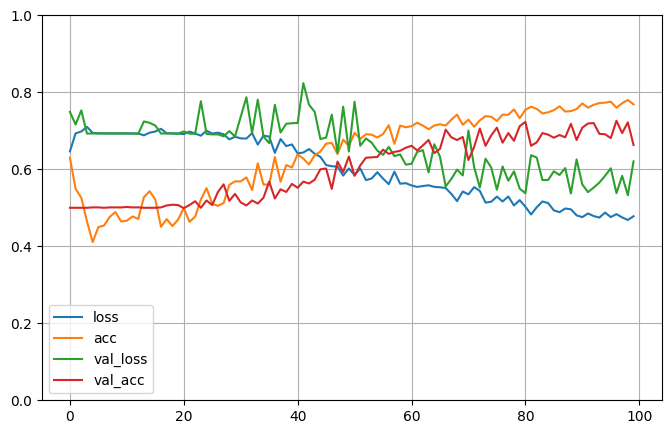

In [63]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [64]:
# model.save("cats_and_dogs")

In [65]:
!tensorboard --bind_all --logdir=./my_logs --port=6006

/bin/bash: /home/kailash/anaconda3/envs/tensorflow1/lib/libtinfo.so.6: no version information available (required by /bin/bash)

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

TensorBoard 2.10.0 at http://kailash-ASUS-TUF-Gaming-A17-FA706IC-FA766IC:6006/ (Press CTRL+C to quit)
W0921 13:47:20.309216 139963295319616 security_validator.py:46] In 3.0, this warning will become an error:
Illegal Content-Security-Policy for script-src: 'unsafe-inline'
W0921 13:47:21.058884 139963278534208 security_validator.py:46] In 3.0, this warning will become an error:
Illegal Content-Security-Policy for script-src: 'unsafe-inline'
W0921 13:47:27.306746 139963278534208 application.py:558] path /data/plugin/profile not found, sending 404
W0921 13:47:27.353830 139963295319616 application.py:558] path /data/plugin/profile/overview_page@;run=run_2022_09_21-13_36_49d